# The birth of the strong components, draft 2.

In this draft, we compute the empirical probabilities from the generating functions of digraphs.

We work with multidigraphs only (for simplicity of presentation), but everything can be extended to
simple digraphs (with or without 2-cycles) if necessary.

## Preliminaries

This draft contains the computation of the coefficients of the generating function.
High-precision arithmetic is used, due to excessive inclusions-exclusions.

We are using the library `ring_series` which provides a fast interface for formal power series manipulation

In [1]:
import sympy as sp
from sympy.polys import ring, QQ, RR
from sympy.polys.ring_series import rs_exp, rs_pow
from sympy.polys.ring_series import rs_series_inversion
import sympy.polys.ring_series as ring_series

In [170]:
from sympy.polys.ring_series import rs_mul

The first auxilliary operation is $ [z^n] F(z) $. We consider only univariate generating functions in the current draft.

In [2]:
def coeff_at(poly, n):
    """
    Operation of coefficient extraction at `z^n`
    """
    if (n,) in poly.as_expr_dict().keys():
        return poly[(n,)]
    else:
        return 0

In [12]:
def rs_fourier(p1, w):
    """
    Coefficientwise multiplication of the coefficient at `z^n` by `exp(-w n^2/2)`
    """
    R = p1.ring
    p = R.zero
    for exp1, v1 in p1.items():
        p[exp1] = v1 / sp.exp(w * exp1[0]**2/2)
    return p

In [173]:
def rs_generalised_exp(r, w, x, n):
    """
    Implementation of the generalised deformed exponential from the paper.
    Can be defined as `rs_fouries[e^{-z} * (1 - zw)**r]`
    """
    basic_poly = rs_mul(rs_exp(-x, x, n), rs_pow(1 - x*w, r, x, n), x, n)
    return rs_fourier(basic_poly, w)

Note that in these two functions below we specify the coefficient field for the first time.
We take advantage of the constructor `sp.polys.RealField` which provides arbitrary precision
floating point arithmetic. I have tried `sympy.polys.QQ` and `sympy.polys.RR` as well,
but exponents do not work well with rationals, and the standard precision for `RR` is
not sufficient.

In [40]:
def p_dag(n, p, prec=200):
    """
    Compute the probability that a random multidigraph MD(n,p) is acyclic.
    """    
    RR_extended = sp.polys.RealField(prec=prec)
    R, x = ring('x', RR_extended)
    w = p
    genf = rs_series_inversion(rs_generalised_exp(0, w, x, n+5), x, n+5)
    return sp.exp(-p * n**2/2) * sp.factorial(n) * coeff_at(genf, n)

In [69]:
def p_elementary(n, p, prec):
    """
    Compute the probability that a random multidigraph MD(n,p) is elementary.
    """    
    RR_extended = sp.polys.RealField(prec=prec)
    R, x = ring('x', RR_extended)
    w = p
    genf = rs_series_inversion(rs_generalised_exp(1, w, x, n+5), x, n+5)
    return sp.exp(-p * n**2/2) * sp.factorial(n) * coeff_at(genf, n)

The decimal representation contains hundreds of digits (we definitely need them, otherwise the results blows up due to inclusions-exclusions) and we need to truncate it for the purpose of readability

In [79]:
n = 1000
prec = 3*n
p = sp.Float(sp.Rational(1,n),precision=prec)
p_elementary(n, p, prec)

0.70645166266688866516801575544120547083309908109492371238114101976652993922930909597781833981205760059281778254538055545604320105686814289346186062407937071715852701498745188209353048861052391042935464412376275027529801016811960483286896918911567987185100015758424699771168000823354289855766742666643204335176075457953036794728086844883232632491929648393846131277157727160570486645988291538611473508432109251128436003375877686073701618248326576100747009712571168015757805075065618179297474164023362195249611301997675767352827403018463165282725885741660851712363876163541378782396870648175263145862238705710269276970753649863144442040505148131191772763866803574125372172014168929691082135475664221092850905487601869344358337675054047125448614186597782395030600666389369297261922557255966057218628377641173001964957230378199503199290227401597481285449195161625411897701341183313062781490043634971115962239

In [85]:
n = 3000
prec = 2*n
p = sp.Float(sp.Rational(1,n),precision=prec)
sp.N(p_elementary(n, p, prec), 20)

0.70446947053205910600

The numerical difference between the probabilities corresponding to `n = 1000` and `n = 3000`

In [87]:
0.7045 - 0.6997

0.0048000000000000265

# Supercritical phase

It is interesting to check some of the assertions that our supercritical approximation contains no mistake. Clearly, from the numerical values it is sometimes not that clear, but we will see.

Let us take $ MD(n, \lambda/n) $, where $ \lambda = 2 $ first.

In [91]:
%%time
n = 300
prec = 2 * n
p = sp.Float(sp.Rational(2,n),precision=prec)
p_elementary(n, p, prec)

CPU times: user 1.45 s, sys: 17.6 ms, total: 1.47 s
Wall time: 1.49 s


0.000000000560779555041553936308397758573777128223298332269455518216406812534379849286439208313538399130001292410204969232822993955906588082707428783904348188961415493630838884360849061824855

The numerical values contain lots of leading zeroes, so we need to be careful.

Next, we enter the numerical constants from the paper.

In [92]:
def alpha(lam):
    return (lam **2 - 1) / (2 * lam) - sp.log(lam)

def beta(lam):
    return (2*lam)**sp.Rational(-1, 3) * (lam - 1)

def a1():
    return -2.338107

def a1_prime():
    return -1.018793

def ai_prime_of_a1():
    return 0.701211

def ai_of_a1_prime():
    return 0.53565666

In [95]:
def sigma_2(lam):
    return -(
        lam**sp.Rational(1,2)
        *
        sp.exp((lam - 1)/6)
        /
        2
        /
        a1_prime()
        /
        ai_of_a1_prime()
    )

In [97]:
sigma_2(sp.Float(2, 20))

1.5307171728036179265

In [101]:
def asymptotic_elem(n, lam):
    """
    Asymptotic probability that a multidigraph `MD(n, lambda/n)` is elementary,
    according to the paper.
    """
    return sigma_2(lam) * sp.exp(
        - alpha(lam)*n
        + a1_prime() * beta(lam) * n**sp.Rational(1,3)
    )

In [135]:
def gamma_2(lam):
    return (
        2**sp.Rational(-2,3) * lam**sp.Rational(5,6)
        * sp.exp((lam - 1)/6)
        / ai_prime_of_a1()
    )

In [136]:
def asymptotic_dag(n, lam):
    """
    Asymptotic probability that a multidigraph `MD(n, lambda/n)` is acyclic,
    according to the paper.
    """
    return gamma_2(lam) * n**sp.Rational(-1,3) * sp.exp(
        - alpha(lam)*n
        + a1() * beta(lam) * n**sp.Rational(1,3)
    )

### n = 100

In [102]:
prec = 20
asymptotic_elem(sp.Float(100, prec), sp.Float(2, prec))

0.00026427657210037663584

In [104]:
n = 100
prec = 2 * n
p = sp.Float(sp.Rational(2,n),precision=prec)
p_elementary(n, p, prec)

0.00017805196733709256087226275855901586708912579873954147091420

We observe that directly comparing these numbers with our eyes is not the best way to see whether the numbers converge in the limit or not.

In [106]:
prec = 20
asymptotic_elem(sp.Float(200, prec), sp.Float(2, prec))

4.1371313056986413767e-7

In [108]:
n = 200
prec = 2 * n
p = sp.Float(sp.Rational(2,n),precision=prec)
float(p_elementary(n, p, prec))

2.824905456792523e-07

Let us start by taking ratios and increasing the value of `n`.

#### n = 100

In [112]:
n = 100
lam = 2
p = sp.Float(sp.Rational(lam,n),precision=prec)
prec = 2 * n
float(asymptotic_elem(sp.Float(n, prec), sp.Float(2, prec)))/float(p_elementary(n, p, prec))

1.4842665096760286

#### n = 200

In [114]:
n = 200
lam = 2
p = sp.Float(sp.Rational(lam,n),precision=prec)
prec = 2 * n
float(asymptotic_elem(sp.Float(n, prec), sp.Float(2, prec)))/float(p_elementary(n, p, prec))

1.4645202712008834

#### n = 300

In [115]:
n = 300
lam = 2
p = sp.Float(sp.Rational(lam,n),precision=prec)
prec = 2 * n
float(asymptotic_elem(sp.Float(n, prec), sp.Float(2, prec)))/float(p_elementary(n, p, prec))

1.4552348473325905

#### n = 400

In [116]:
n = 400
lam = 2
p = sp.Float(sp.Rational(lam,n),precision=prec)
prec = 2 * n
float(asymptotic_elem(sp.Float(n, prec), sp.Float(2, prec)))/float(p_elementary(n, p, prec))

1.4494625031365636

In [121]:
n = 500
lam = 2
p = sp.Float(sp.Rational(lam,n),precision=prec)
prec = 2 * n
float(asymptotic_elem(sp.Float(n, prec), sp.Float(2, prec)))/float(p_elementary(n, p, prec))

1.4453925470133777

In [122]:
n = 600
lam = 2
p = sp.Float(sp.Rational(lam,n),precision=prec)
prec = 2 * n
float(asymptotic_elem(sp.Float(n, prec), sp.Float(2, prec)))/float(p_elementary(n, p, prec))

1.4423068546190958

In [123]:
n = 800
lam = 2
p = sp.Float(sp.Rational(lam,n),precision=prec)
prec = 2 * n
float(asymptotic_elem(sp.Float(n, prec), sp.Float(2, prec)))/float(p_elementary(n, p, prec))

1.4378372888161337

#### n = 1000
It starts taking a bit longer, so we measure the time

In [128]:
%%time
n = 1000
lam = 2
prec = 2*n
p = sp.Float(sp.Rational(lam,n),precision=prec)
float(asymptotic_elem(sp.Float(n, prec), sp.Float(2, prec)))/float(p_elementary(n, p, prec))

CPU times: user 22.7 s, sys: 154 ms, total: 22.9 s
Wall time: 23.1 s


1.434677725492042

In [237]:
def get_ratio_elem(n, lam):
    """
    A dedicated function to compute the ratio between the theoretical prediction
    and empirical observations, the supercritical probability that a digraph
    is elementary
    """
    prec = 3 * n
    p = sp.Float(sp.Rational(lam,n),precision=prec)
    return (
        float(asymptotic_elem(
            sp.Float(n, prec),
            sp.Float(2, prec))
        ) / float(
            p_elementary(n, p, prec)
        )
    )

In [138]:
get_ratio_elem(100, 2)

1.4842665096760286

In [155]:
def get_ratio_dag(n, lam):
    """
    A dedicated function to compute the ratio between the theoretical prediction
    and empirical observations, the supercritical probability that a digraph is acyclic.
    """    
    prec = 3 * n
    p = sp.Float(sp.Rational(lam,n),precision=prec)
    return (
        float(asymptotic_dag(
            sp.Float(n, prec),
            sp.Float(lam, prec))
        ) / float(
            p_dag(n, p, prec)
        )
    )

In [144]:
import matplotlib.pyplot as plt

In [161]:
n_range = range(50, 600, 7) 
lam_15_value = [get_ratio_dag(n, 1.5) for n in n_range]
lam_2_value = [get_ratio_dag(n, 2) for n in n_range]
lam_4_value = [get_ratio_dag(n, 4) for n in n_range]

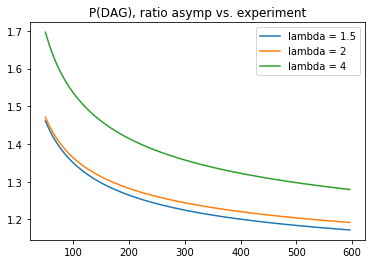

In [162]:
plt.title("P(DAG), ratio asymp vs. experiment")
plt.plot(n_range, lam_15_value,label="lambda = 1.5")
plt.plot(n_range, lam_2_value,label="lambda = 2")
plt.plot(n_range, lam_4_value,label="lambda = 4")
plt.legend()

These plots converge to 1, but quite slowly. We also observe that when `lambda` is larger, we need larger `n` to expect convergence.

# Complex component and further numerical values

In [185]:
def p_bicyclic(n, p, prec):
    """
    Compute the coefficient of the generating function `Psi_2(x,w)/Psi_{-1}(x,w)^2`.
    This corresponds to the probability that a digraph has one complex bicyclic component
    (with a cubic kernel), multiplied by 2, as we don't insert the compensation factor.
    """
    RR_extended = sp.polys.RealField(prec=prec)
    R, x = ring('x', RR_extended)
    w = p
    genf = rs_mul(
        rs_generalised_exp(-2, w, x, n+5)
        ,
        rs_pow(rs_series_inversion(rs_generalised_exp(1, w, x, n+5), x, n+5), 2, x, n+5)
        ,
        x, n+5
    )
    return p * sp.exp(-p * n**2/2) * sp.factorial(n) * coeff_at(genf, n)

In [220]:
def get_p_elementary_of_mu(n, mu):
    """
    An auxilliary function to compute the critical probability that a digraph is elementary,
    as a function of `n` and `mu`.
    """
    prec = 2 * n
    p = sp.Float(sp.Rational(1,n)*(1 + mu * n**(-1/3)),precision=prec)
    return float(p_elementary(n, p, prec))

In [221]:
get_p_elementary_of_mu(100, -3)

0.36692889853558247

### Numerical values used in the paper

Start constructing numerical tables for $ n \in \{ 100, 500, 1000, 2000, 3000 \} $, and $ \mu \in [-3,3] $.

In [222]:
for mu in [-3,-2,-1,0,1,2,3]:
    print("P(n,mu)=",get_p_elementary_of_mu(100, mu))

P(n,mu)= 0.9978271382631824
P(n,mu)= 0.9851370396962627
P(n,mu)= 0.9214905916438937
P(n,mu)= 0.7132290624097936
P(n,mu)= 0.36692889853558247
P(n,mu)= 0.10522003867715868
P(n,mu)= 0.015741730136312842


In [223]:
for mu in [-3,-2,-1,0,1,2,3]:
    print("P(n,mu)=",get_p_elementary_of_mu(500, mu))

P(n,mu)= 0.9936892391453764
P(n,mu)= 0.9767322337564219
P(n,mu)= 0.9109939702026606
P(n,mu)= 0.7080705319203177
P(n,mu)= 0.351744454286137
P(n,mu)= 0.08151382385378002
P(n,mu)= 0.006981632821697321


In [224]:
%%time
for mu in [-3,-2,-1,0,1,2,3]:
    print("P(n,mu)=",get_p_elementary_of_mu(1000, mu))

P(n,mu)= 0.9921633438828489
P(n,mu)= 0.9741187098752032
P(n,mu)= 0.9079495733591028
P(n,mu)= 0.7064516626668886
P(n,mu)= 0.346844437491889
P(n,mu)= 0.07442674872541379
P(n,mu)= 0.005112854548573635
CPU times: user 2min 30s, sys: 1.85 s, total: 2min 31s
Wall time: 2min 36s


In [225]:
%%time
for mu in [-3,-2,-1,0,1,2,3]:
    print("P(n,mu)=",get_p_elementary_of_mu(2000, mu))

P(n,mu)= 0.990862570371549
P(n,mu)= 0.9720001915354768
P(n,mu)= 0.9055336547222546
P(n,mu)= 0.7051268259999971
P(n,mu)= 0.34279349031692313
P(n,mu)= 0.0687839155358463
P(n,mu)= 0.0038641821985566554
CPU times: user 17min 30s, sys: 6.01 s, total: 17min 36s
Wall time: 17min 54s


In [226]:
%%time
for mu in [-3,-2,-1,0,1,2,3]:
    print("P(n,mu)=",get_p_elementary_of_mu(3000, mu))

P(n,mu)= 0.9902029464940547
P(n,mu)= 0.9709568375368778
P(n,mu)= 0.9043585142164898
P(n,mu)= 0.7044694705320592
P(n,mu)= 0.3407706962591127
P(n,mu)= 0.06604116996332303
P(n,mu)= 0.003331728360174104
CPU times: user 56min 23s, sys: 7.54 s, total: 56min 30s
Wall time: 56min 40s


In [227]:
def get_p_dag_of_mu(n, mu):
    """
    An auxilliary function to compute the (rescaled) critical probability that a digraph
    is acyclic as a function of `n` and `mu`.
    """
    prec = 2 * n
    p = sp.Float(sp.Rational(1,n)*(1 + mu * n**(-1/3)),precision=prec)
    return n**(1/3) * float(p_dag(n, p, prec))

In [228]:
%%time
for n in [100, 500, 1000, 2000, 3000]:
    print("n =",n)
    for mu in [-3,-2,-1,0,1,2,3]:
        print("P(n,mu)=",get_p_dag_of_mu(n, mu))

n = 100
P(n,mu)= 3.00670995655363
P(n,mu)= 2.0342337181676857
P(n,mu)= 1.140681475569412
P(n,mu)= 0.4630441989795451
P(n,mu)= 0.11671847401714751
P(n,mu)= 0.016428454134738826
P(n,mu)= 0.0012480099009472077
n = 500
P(n,mu)= 3.020111347368173
P(n,mu)= 2.0562074136579915
P(n,mu)= 1.166423676174294
P(n,mu)= 0.4739374819771643
P(n,mu)= 0.11007488669997265
P(n,mu)= 0.011474438587371313
P(n,mu)= 0.0004468675362176245
n = 1000
P(n,mu)= 3.0252204138162457
P(n,mu)= 2.063358393921107
P(n,mu)= 1.1741028263709552
P(n,mu)= 0.4770511989006787
P(n,mu)= 0.10793011601978114
P(n,mu)= 0.01012017578706228
P(n,mu)= 0.0003041246641854176
n = 2000
P(n,mu)= 3.0296390690020365
P(n,mu)= 2.06925688740073
P(n,mu)= 1.1802536814480582
P(n,mu)= 0.47950238093202313
P(n,mu)= 0.10615809392082318
P(n,mu)= 0.009083640586492907
P(n,mu)= 0.0002158980577421835
n = 3000
P(n,mu)= 3.0319009803961707
P(n,mu)= 2.0721940883353827
P(n,mu)= 1.1832621012534446
P(n,mu)= 0.48068761704093144
P(n,mu)= 0.10527383903840315
P(n,mu)= 0.0085

In [229]:
def get_p_bicyclic_of_mu(n, mu):
    """
    An auxilliary function to compute the critical probability that a digraph
    has one bicyclic component (times two) as a function of `n` and `mu`.
    """
    prec = 2 * n
    p = sp.Float(sp.Rational(1,n)*(1 + mu * n**(-1/3)),precision=prec)
    return float(p_bicyclic(n, p, prec))

In [230]:
%%time
for n in [100, 500, 1000, 2000, 3000]:
    print("n =",n)
    for mu in [-3,-2,-1,0,1,2,3]:
        print("P(n,mu)=",get_p_bicyclic_of_mu(n, mu))

n = 100
P(n,mu)= 0.012530912394965886
P(n,mu)= 0.053108394055152906
P(n,mu)= 0.1851477690029509
P(n,mu)= 0.3985882124692773
P(n,mu)= 0.4115339915761694
P(n,mu)= 0.1877047548051552
P(n,mu)= 0.038846097785652095
n = 500
P(n,mu)= 0.02015016716581893
P(n,mu)= 0.05872864686746007
P(n,mu)= 0.16426319688828392
P(n,mu)= 0.3289797748136031
P(n,mu)= 0.32844425453667675
P(n,mu)= 0.1232078342699115
P(n,mu)= 0.014804452949832144
n = 1000
P(n,mu)= 0.021916226308514378
P(n,mu)= 0.0594537069806244
P(n,mu)= 0.15810608866035947
P(n,mu)= 0.31098320349151604
P(n,mu)= 0.30744610253127475
P(n,mu)= 0.10754946930884692
P(n,mu)= 0.01042715888837119
n = 2000
P(n,mu)= 0.023162324165253382
P(n,mu)= 0.05977269336563098
P(n,mu)= 0.15322793902005322
P(n,mu)= 0.29735936649029754
P(n,mu)= 0.2916917940744892
P(n,mu)= 0.09602625731006278
P(n,mu)= 0.007655591649834861
n = 3000
P(n,mu)= 0.023718049987376574
P(n,mu)= 0.05985069711525291
P(n,mu)= 0.15086235483013632
P(n,mu)= 0.290937232689146
P(n,mu)= 0.2843088613218346
P(n

In [231]:
# Then, we have to divide everything by 2 because I forgot to include the compensation factor
# and I don't want to run again 3 hours of computation time

narray = [
[
0.012530912394965886,
0.053108394055152906,
0.1851477690029509  ,
0.3985882124692773  ,
0.4115339915761694  ,
0.1877047548051552  ,
0.038846097785652095
],
[
0.02015016716581893,
0.05872864686746007,
0.16426319688828392,
0.3289797748136031 ,
0.32844425453667675,
0.1232078342699115 ,
0.014804452949832144
],
[
0.021916226308514378,
0.0594537069806244  ,
0.15810608866035947 ,
0.31098320349151604 ,
0.30744610253127475 ,
0.10754946930884692 ,
0.01042715888837119
],
[
0.023162324165253382,
0.05977269336563098 ,
0.15322793902005322 ,
0.29735936649029754 ,
0.2916917940744892  ,
0.09602625731006278 ,
0.007655591649834861
],
[
0.023718049987376574,
0.05985069711525291 ,
0.15086235483013632 ,
0.290937232689146   ,
0.2843088613218346  ,
0.09070120970400182 ,
0.006512834962910485
]
]


In [233]:
[
    [
        x/2 for x in col
    ]
    for col in narray
]

[[0.006265456197482943,
  0.026554197027576453,
  0.09257388450147545,
  0.19929410623463864,
  0.2057669957880847,
  0.0938523774025776,
  0.019423048892826048],
 [0.010075083582909466,
  0.029364323433730036,
  0.08213159844414196,
  0.16448988740680154,
  0.16422212726833837,
  0.06160391713495575,
  0.007402226474916072],
 [0.010958113154257189,
  0.0297268534903122,
  0.07905304433017973,
  0.15549160174575802,
  0.15372305126563737,
  0.05377473465442346,
  0.005213579444185595],
 [0.011581162082626691,
  0.02988634668281549,
  0.07661396951002661,
  0.14867968324514877,
  0.1458458970372446,
  0.04801312865503139,
  0.0038277958249174305],
 [0.011859024993688287,
  0.029925348557626456,
  0.07543117741506816,
  0.145468616344573,
  0.1421544306609173,
  0.04535060485200091,
  0.0032564174814552426]]

The end.